In [1]:
import numpy as np
import pandas as pd
import time
import datetime
import gc
import random
from nltk.corpus import stopwords
import re

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [3]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

In [4]:
def get_accuracy(predictions,labels):
    flattened_predictions = np.argmax(predictions, axis=1).flatten()
    flattened_labels = labels.flatten()
    return np.sum(flattened_predictions==flattened_labels)/len(flattened_labels)

## Preprocessing

In [5]:
# remove urls, html tags, punctuations, stopwords, emojis
my_stopwords = stopwords.words('english')

In [6]:
def data_preprocess(sentence):
    '''
    lowercase the sentence
    replace special cahracters with spacebar
    remove urls
    remove special characters
    '''
    
    sentence = sentence.lower()
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ",sentence)
    sentence = re.sub(r"http\S+", "",sentence)    
    
    
    html=re.compile(r'<.*?>') 
    sentence = html.sub(r'',sentence)
    
    characters = "/><|{}^@#!?+();$=&*[]-%.:_`''" 
    for c in characters:
        sentence = sentence.replace(c,'')
        
    sentence = [word.lower() for word in sentence.split() if word.lower() not in my_stopwords]
    cleaned_sentence = " ".join(sentence)
    
    ## This section is taken from another project to refer emojis on twitter tweets
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    #print(sentence)
    sentence = emoji_pattern.sub(r'', cleaned_sentence)
    return sentence

In [7]:
train_data['text'] = train_data['text'].apply(lambda x: data_preprocess(x))

In [8]:
# Let's look at our cleaned sentence now
train_data['text']

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       , people receive wildfires evacuation orders c...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    aria ahrary thetawniest control wild fires cal...
7610            utc km volcano hawaii http tco zdtoyd ebj
7611    police investigating e bike collided car littl...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

In [9]:
# we need a tokenizer to tag the words with IDs and tokenize them.
#We use the original bert tokinzer from transformers libreary
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [10]:
# let's segregate our tweets and labels
tweets = train_data.text.values
target = train_data.target.values
num_classes = 2

In [11]:
# let's get the max_length of sentence
max_len = 0
for i in range(len(tweets)):    
    l = len(tweets[i].split())
    max_len = max(l,max_len)
print("Maximum words in a tweet are:",max_len)

Maximum words in a tweet are: 27


In [12]:
# while tokenizing we need to add the 'CLS' token since we are doing classification and 'SEP' to indicate end of sentence
# so we add the special tokens during tokenization
# Also if the word is not present in the token library then the 'UNK' id will be used
# We need an attention mask for PAD tokens too
# So we use the encode_plus for our tokenizer 

input_ids = []
attention_masks = []

for each_sentence in tweets:
    encoded_dict = tokenizer.encode_plus(each_sentence,
                                        max_length=max_len,
                                        pad_to_max_length=True,
                                        return_attention_mask=True,
                                        add_special_tokens=True,
                                        return_tensors='pt')
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\users\bharath\anaconda3\envs\pytorch_env\lib\site-packages\transformers\tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [13]:
# Now we convert our training data to tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
target = torch.tensor(target)


## Now we proceed to training BERT

In [14]:
# Input dimensions = max_len = 27
# Prediction is 1 or 0

In [15]:
# We combine our training data
dataset = TensorDataset(input_ids, attention_masks, target)

training_size = int(len(dataset)*0.8)
testing_size = len(dataset)-int(len(dataset)*0.8)

# split dataset to train and test 80%train 20% validation
train_dataset, val_dataset = random_split(dataset, [training_size,testing_size])

In [16]:
batch_size = 32

In [17]:
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size 
        )

In [18]:
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [19]:
pretrained = "bert-base-uncased"
config = BertConfig.from_pretrained(pretrained)
config.num_hidden_layers = 6
config.num_labels = num_classes

In [20]:
model = BertForSequenceClassification(config)

# Tell pytorch to run this model on the GPU.
model = model.cuda()

In [21]:
optimizer = torch.optim.Adam(model.parameters(),
                  lr = 1e-4, 
                )

In [22]:
# authors recommend 2-4
epochs = 2
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [23]:
training_statistics = []
start_time = time.time()

In [24]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [25]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [26]:
training_stats = []

In [27]:
total_t0 = time.time()

In [28]:
# referred from https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        #model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        #print(output[1])
        
        #loss = loss_fn(logits, b_labels)
        
        loss = output.loss
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    best_eval_accuracy = np.Inf
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            output= model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        loss = output.loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    if avg_val_accuracy < best_eval_accuracy:
        
        torch.save(model, 'bert_model_6layers')
        best_eval_accuracy = avg_val_accuracy
    #print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    #print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    191.    Elapsed: 0:00:06.
  Batch    80  of    191.    Elapsed: 0:00:12.
  Batch   120  of    191.    Elapsed: 0:00:18.
  Batch   160  of    191.    Elapsed: 0:00:24.

  Average training loss: 0.72
  Training epoch took: 0:00:28

Running Validation...
  Accuracy: 0.42

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    191.    Elapsed: 0:00:06.
  Batch    80  of    191.    Elapsed: 0:00:12.
  Batch   120  of    191.    Elapsed: 0:00:17.
  Batch   160  of    191.    Elapsed: 0:00:23.

  Average training loss: 0.69
  Training epoch took: 0:00:28

Running Validation...
  Accuracy: 0.58

Training complete!


In [29]:
pd.DataFrame(training_stats).to_csv("Training_statistics_6layers.csv")

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
val_losses = []
train_losses = []
val_accuracy = []
for e in range(len(training_stats)):
    train_losses.append(training_stats[e]['Training Loss'])
    val_losses.append(training_stats[e]['Valid. Loss'])
    val_accuracy.append(training_stats[e]['Valid. Accur.'])

The BERT authors recommend to train epochs between 2 and 4. 


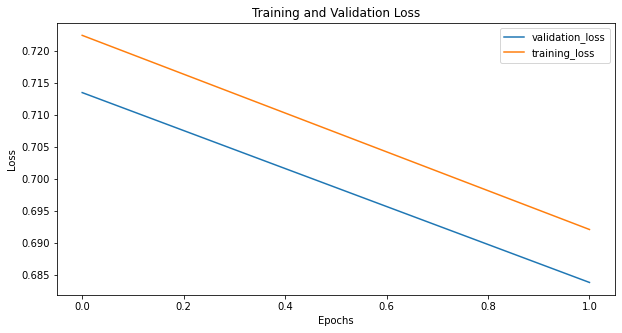

In [32]:
print("The BERT authors recommend to train epochs between 2 and 4. ")
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="validation_loss")
plt.plot(train_losses,label="training_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

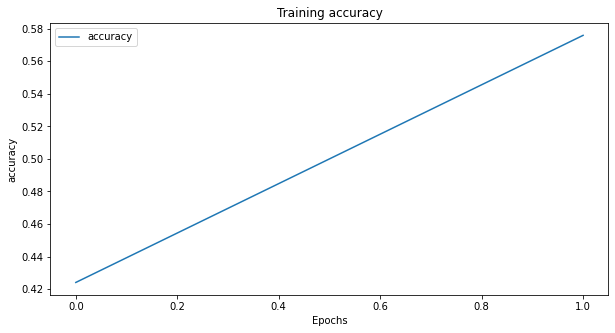

In [33]:
plt.figure(figsize=(10,5))
plt.title("Training accuracy")
plt.plot(val_accuracy,label="accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [34]:
# Load best model
model = torch.load('bert_model_6layers')

In [35]:
test_data['text'] = test_data['text'].apply(lambda x:data_preprocess(x))
test_tweets = test_data['text'].values

In [36]:
test_input_ids = []
test_attention_masks = []
for tweet in test_tweets:
    encoded_dict = tokenizer.encode_plus(
                        tweet,                     
                        add_special_tokens = True, 
                        max_length = max_len,           
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

c:\users\bharath\anaconda3\envs\pytorch_env\lib\site-packages\transformers\tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [37]:
test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [38]:
predictions = []
for batch in test_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            output= model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask)
            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()
            
            predictions.extend(list(pred_flat))

In [39]:
df_output = pd.DataFrame()
df_output['id'] = test_data['id']
df_output['target'] =predictions
df_output.to_csv('Bert6layers.csv',index=False)